In [1]:
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray'):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    plt.show()

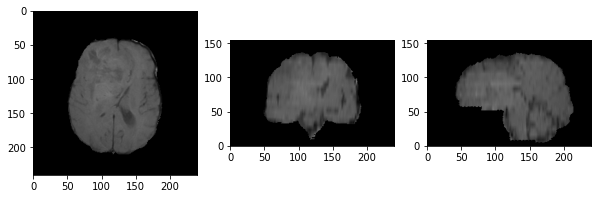

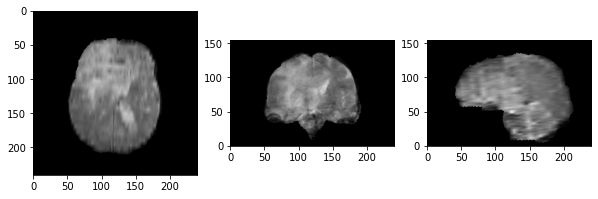

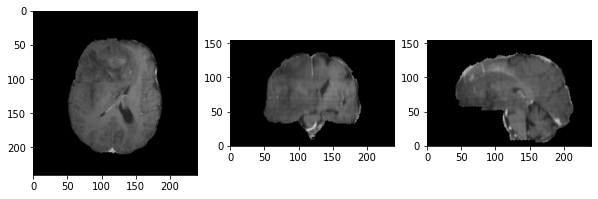

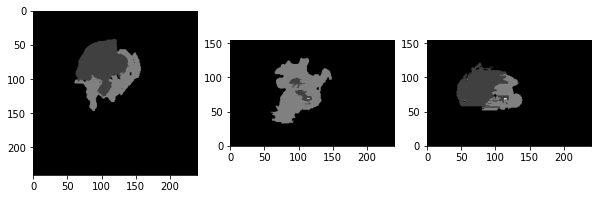

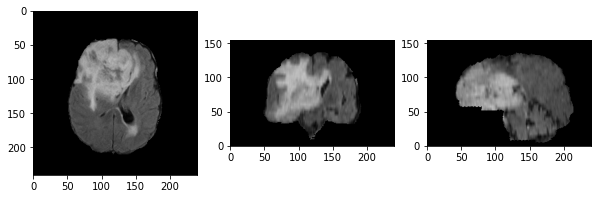

(240, 240, 155)
(1.0, 1.0, 1.0)


In [3]:
# Brats data path
data_dir_name = '/vol/bitbucket/sc5316/Brats17TrainingData/LGG/'
samples = os.listdir(data_dir_name)

# Image
image_filename = data_dir_name + samples[3] + '/' + samples[3] + '_t1.nii.gz'
img = sitk.ReadImage(image_filename)

image2_filename = data_dir_name + samples[3] + '/' + samples[3] + '_t2.nii.gz'
img2 = sitk.ReadImage(image2_filename)

image3_filename = data_dir_name + samples[3] + '/' + samples[3] + '_t1ce.nii.gz'
img3 = sitk.ReadImage(image3_filename)

image4_filename = data_dir_name + samples[3] + '/' + samples[3] + '_seg.nii.gz'
img4 = sitk.ReadImage(image4_filename)

image5_filename = data_dir_name + samples[3] + '/' + samples[3] + '_flair.nii.gz'
img5 = sitk.ReadImage(image5_filename)

display_image(img)
display_image(img2)
display_image(img3)
display_image(img4)
display_image(img5)

print(img4.GetSize())
print(img4.GetSpacing())

In [4]:
def zero_mean_unit_var(image):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    mean = np.mean(img_array[img_array>0])
    std = np.std(img_array[img_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
#         img_array[img_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing), -1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    if is_label:
        resample.SetDefaultPixelValue(0)
    else:
        resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)
            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            #pre=processing
            img = zero_mean_unit_var(img)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)

        return {'img': image, 'seg': seg}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]

In [12]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

print('Device: ' + str(device))

Device: cpu


In [6]:
rnd_seed = 42 #fixed random seed

img_size = [88,88,88]
img_spacing = [2.2,2.2,2.2]

num_epochs = 150
learning_rate = 0.01
batch_size = 8
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [7]:
files_seg_img = [data_dir_name + s + '/' + s + '_flair.nii.gz' for s in samples]
files_seg_seg = [data_dir_name + s + '/' + s + '_seg.nii.gz' for s in samples]
# Load training data
dataset_train = ImageSegmentationDataset(files_seg_img[:10], files_seg_seg[:10], img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)

dataset_val = ImageSegmentationDataset(files_seg_img[55:60], files_seg_seg[55:60], img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)

dataset_test = ImageSegmentationDataset(files_seg_img[65:70], files_seg_seg[65:70], img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Image: Brats17_TCIA_615_1_flair.nii.gz


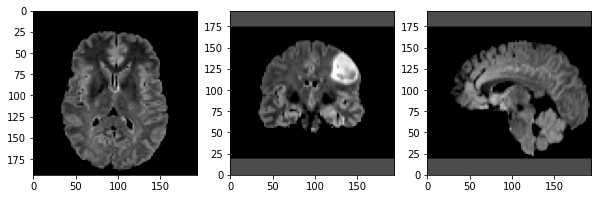

Segmentation


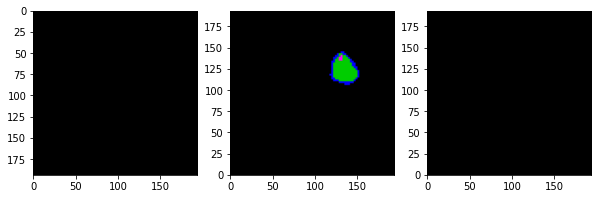

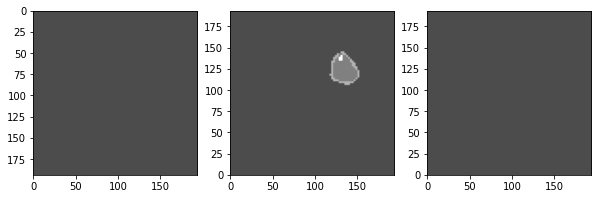

(88, 88, 88)


In [8]:
sample = dataset_train.get_sample(1)
img_name = dataset_val.get_img_name(1)
seg_name = dataset_val.get_seg_name(1)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=1)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
display_image(sample['seg'], window=5, level=1)
print(sample['img'].GetSize())

In [9]:
#Downsampling component of the U-Net
class UnetDown(nn.Module):

    def __init__(self, in_channels,out_channels):
        super(UnetDown, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3,padding=1)
        self.batch_norm = nn.BatchNorm3d(out_channels)
        self.pool  = nn.MaxPool3d(2)
        self.dropout = nn.Dropout3d(p=0.5)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.batch_norm(x))
#         x_downsample = self.dropout(self.pool(x))
        x_downsample = self.pool(x)
        return x, x_downsample


#Upsampling of the U-Net
class UnetUp(nn.Module):

    def __init__(self, in_channels):
        super(UnetUp, self).__init__()
        self.upconv = nn.ConvTranspose3d(in_channels, in_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv3d(2 * in_channels, int(in_channels / 2), kernel_size=3,padding=1)
        self.batch_norm = nn.BatchNorm3d(int(in_channels/2))
        self.dropout = nn.Dropout3d(p=0.5)
  
    def forward(self, x_up, x_down):
        x_up = self.upconv(x_up)
        concat_fm = torch.cat((x_up, x_down), 1)
        x = self.conv1(concat_fm)
#         x = self.dropout(F.relu(self.batch_norm(x)))
        x = F.relu(self.batch_norm(x))
        return x

class Unet(nn.Module):
  
    def __init__(self,in_channels, out_channels, num_classes):
        super(Unet,self).__init__()
        self.encode1 = UnetDown(in_channels, out_channels)
        self.encode2 = UnetDown(out_channels, 2 * out_channels)
        self.conv1 = nn.Conv3d(2 * out_channels, 2 * out_channels, kernel_size=3, padding=1)
        self.decode1 = UnetUp(2 * out_channels)
        self.decode2 = UnetUp(out_channels)
        self.out_conv = nn.Conv3d(int(out_channels/2),num_classes,kernel_size=3, padding=1)


    def forward(self, x):
        enc1 = self.encode1(x)
        enc2 = self.encode2(enc1[1])
        x1 = self.conv1(enc2[1])
        dec1 = self.decode1(x1,enc2[0])
        dec2 = self.decode2(dec1,enc1[0])
        x_out = self.out_conv(dec2)
#         x_out = F.softmax(x_out, dim=1)
        return x_out

In [17]:
# torch.cuda.empty_cache()

model_dir = os.path.join(out_dir, 'segmentation_model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = Unet(1, 32, 4)
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#     model = nn.DataParallel(model)

model.to(device)
model.train()

    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        print(img.size())
        print(seg.size())
        optimizer.zero_grad()
        prd = model(img)
        print(prd.size())
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        print(prd_flat.size())
        print(seg_flat.size())
        print(seg_flat.squeeze(1).size())
        loss = F.cross_entropy(prd_flat, seg_flat.squeeze(1))
        del img
        del seg
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                prd_flat = prd.view(prd.size(0), prd.size(1), -1)
                seg_flat = seg.view(seg.size(0), seg.size(1), -1)
                loss_val += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
                sum_pts += seg_flat.size(2)
                
        print(prd.size())
        prd = torch.argmax(prd, dim=1)
        print(prd.size())
        print(prd.cpu().squeeze().numpy().shape)
#         prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
#         prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.float32))
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy())

        select = sitk.VectorIndexSelectionCastImageFilter()
        channel1_image = select.Execute(prediction, 0, sitk.sitkUInt8)
        channel2_image = select.Execute(prediction, 1, sitk.sitkUInt8)
        channel3_image = select.Execute(prediction, 2, sitk.sitkUInt8)
        
        compose = sitk.ComposeImageFilter()
        composed_image = compose.Execute(channel1_image, channel2_image, channel3_image)
        

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
#         display_image(sitk.LabelToRGB(prediction))
#         display_image(sitk.LabelToRGB(composed_image))
        display_image(composed_image)

torch.save(model.state_dict(), os.path.join(model_dir, 'model2.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

START TRAINING...
torch.Size([8, 1, 88, 88, 88])
torch.Size([8, 1, 88, 88, 88])
torch.Size([8, 4, 88, 88, 88])
torch.Size([8, 4, 681472])
torch.Size([8, 1, 681472])
torch.Size([8, 681472])


IndexError: Target 4 is out of bounds.

In [ ]:
def get_dice_scores(gt, pred, label):
    
    gt = sitk.GetArrayFromImage(gt)
    pred = sitk.GetArrayFromImage(pred)    
    
    gt = gt.flatten()
    pred = pred.flatten()
    TP = len(np.where((gt==label) & (pred==label))[0])
    FP = len(np.where((gt!=label) & (pred==label))[0])
    FN = len(np.where((gt==label) & (pred!=label))[0])

    return 2 * TP / ((2 * TP) + FP + FN)

In [ ]:
model_dir = os.path.join(out_dir, 'segmentation_model')
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = Unet(1,32,4).to(device)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model2.pt')))
model.to(device)
model.eval()
    
csf_dice_scores = []
gm_dice_scores  = []


print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)
        seg_flat = seg.view(seg.size(0), seg.size(1), -1)
        loss_test += F.cross_entropy(prd_flat, seg_flat.squeeze(1), reduction='sum').item()
        sum_pts += seg_flat.size(2)        
        
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        
        csf_dice_scores.append(get_dice_scores(sample['seg'], prediction, 1))
        gm_dice_scores.append(get_dice_scores(sample['seg'], prediction, 2))
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        idx_test += 1
        
loss_test /= sum_pts

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

In [ ]:
####################TEST##########################
fig, axes = plt.subplots(1,3,figsize=(10,4))
fig.tight_layout()
axes[0].title.set_text('csf')
axes[0].boxplot(csf_dice_scores)
axes[1].title.set_text('gm')
axes[1].boxplot(gm_dice_scores)